# Understanding K-Nearest Neighbors Algorithms

Today, we'll look at a dataset relating the beer a person drinks to the schnitzel they're predicted to eat at Oktoberfest: 

In [2]:
# import all the packages upfront (personal preference)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
# you might need this if you work on Mac, feel free to delete it otherwise
cd

In [4]:
# load the beer data and have a quick look
oktoberfest = pd.read_csv("/Volumes/Extreme_SSD/WORK/teaching 2025/TB1/GEOG30045_2024_TB-1/oktoberfest.csv")
oktoberfest

,beer,schnitzel
0,1.06,140
1,1.59,159
2,2.86,105
3,2.44,117
4,2.78,96
5,3.04,94
6,3.47,144
7,0.77,116
8,2.25,121
9,2.39,114


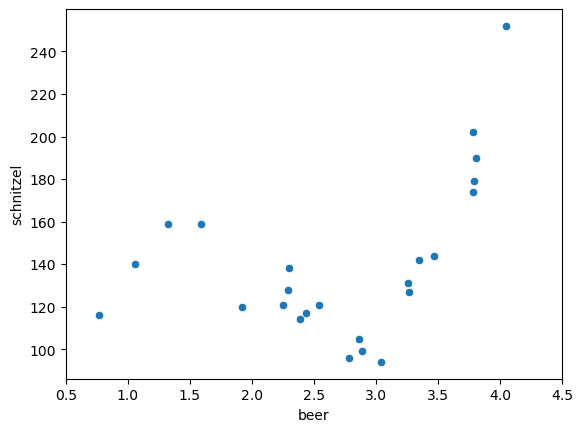

In [5]:
# plot the number of beera vs number of schnitzels on a graph
# notice the numbers, beer is an integer, while schnitzel is regcorded in grams
sns.scatterplot(
    data=oktoberfest, 
    x="beer", 
    y="schnitzel"
)

plt.xlim(0.5, 4.5)

plt.show()

## Comprehension Check

1. Using the plot above, what is your guess for:

    a. how much *schnitzel* would you guess would be eaten by someone who drank 1 beer?
    
    b. how much *schnitzel* would you guess would be eaten by someone who drank 2.5 beers? 

    c. how much *schnitzel* would you guess would be eaten by someone who drank no beer? 

    d. how much *beer* would be drank by someone someone who ate 100 grams of schnitzel?

    e. how much *beer* would be drank by someone who ate 125 grams of schitzel? 

    c. If you had to explain how you made these guesses, what would you say you did? 



# A manual KNN

Imagine that we want to predict how much schnitzel would be eaten by a person who drank *exactly* three beers. A KNN learner will construct a prediction from the *average* of the nearest *k* training observations' $y$ values. In this case, nearness is calculated *only using* $x$. This is because we might not *actually observe $y$* in the real world: remember we're focused primarly on *making predictions* in Data Science, and sometimes we might want to make predictions about things that haven't happened yet! 

So, thinking about a prediction for someone who drank exactly three beers, we can think of the following plot:

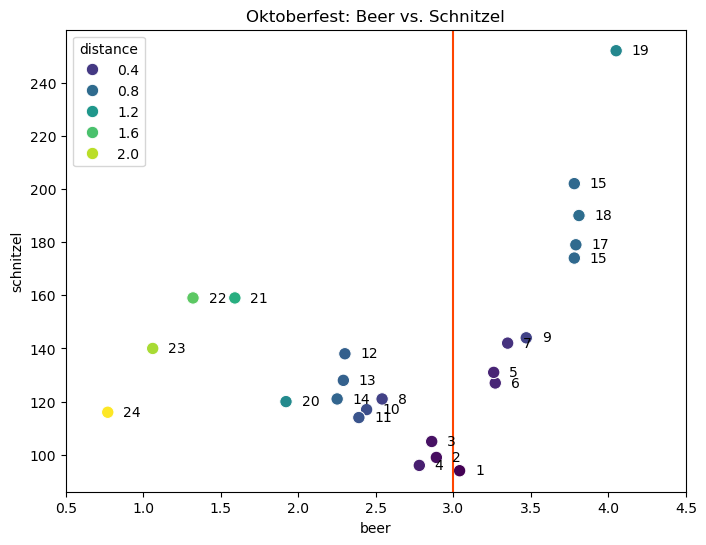

In [6]:

# create distance and nearness_rank
# think about this as a way to quantify how "close" each observation is to the ideal point (3, 0)
oktoberfest = oktoberfest.assign(
    distance=(oktoberfest["beer"] - 3).abs()
)
oktoberfest["nearness_rank"] = oktoberfest["distance"].rank()


# put that on a graph
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=oktoberfest,
    x="beer",
    y="schnitzel",
    hue="distance",
    palette="viridis",
    s=80
)

# vertical reference line for the baseline 3
plt.axvline(x=3, color="orangered")

# add labels 
for _, row in oktoberfest.iterrows():
    plt.text(
        row["beer"] + 0.1,  # shift text right so it does not clash with the points
        row["schnitzel"],
        int(row["nearness_rank"]),
        va="center"
    )

# clean up the axes
plt.xlim(0.5, 4.5)
plt.xlabel("beer")
plt.ylabel("schnitzel")
plt.title("Oktoberfest: Beer vs. Schnitzel")

plt.show()

If we had trained a $k=1$ learner, then we would pick only the nearest observation to 3 beers, and predict that the schnitzel eaten by someone who drank 3 beers is *exactly* the amount of schnitzel eaten by someone who drank the nearest to 3 beers. This is observation $1$ in the plot above, which has a value of 94 grams. However, if we picked the nearest $k=4$ observations: 

In [7]:
# arrange by distance and take first 4 rows
result = oktoberfest.sort_values("distance").head(4)
result

,beer,schnitzel,distance,nearness_rank
5,3.04,94,0.04,1.0
19,2.89,99,0.11,2.0
2,2.86,105,0.14,3.0
4,2.78,96,0.22,4.0


In [8]:
# calculate the mean schnitzel for the nearest 4 observations
oktoberfest.sort_values("distance").head(4)['schnitzel'].mean()

98.5

Our average would instead be 98.5 grams. In fact, our predicted value for someone who drinks three beers really strongly depends on $k$; as you increase $k$, your prediction generally increases:

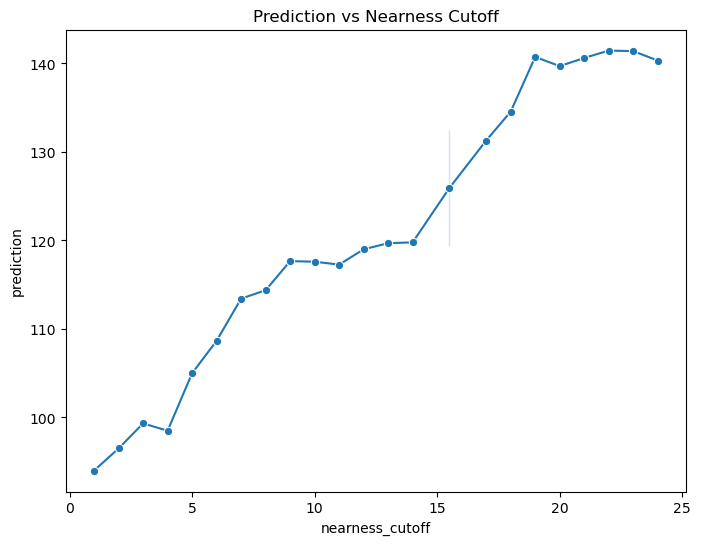

In [9]:
# rank distances (1 = closest to 3)
# we already shifted the beer column by 3, so now we just need to rank the distances
oktoberfest["nearness_cutoff"] = oktoberfest["distance"].rank()

# sort by nearness_cutoff
oktoberfest = oktoberfest.sort_values("nearness_cutoff")

# create a prediction = cumulative mean of schnitzel by rank
oktoberfest["prediction"] = (
    oktoberfest["schnitzel"].cumsum() / oktoberfest["nearness_cutoff"]
)

# plot on graph
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=oktoberfest,
    x="nearness_cutoff",
    y="prediction",
    marker="o"
)

# add labels
plt.xlabel("nearness_cutoff")
plt.ylabel("prediction")
plt.title("Prediction vs Nearness Cutoff")

plt.show()

This is because the points that are *nearest to 3 beers* are have relatively low schnitzel consumption. The points that are very far from 3 have much higher schnitzel consumption. 


## Comprehension Check

1. What is the predicted `schnitzel` value when $k=n$? What does that value represent? 
2. Why do we see a big jump when `nearness_cutoff`$=15$?


## Thinking about KNN curves

Below, we can visualize what the predicted schnizel consumption is when you pick different values of $k$. For each of these curves, we just follow a very simple rule. 

1. find a location on the $x$ axis
2. find the $k$ observations that have the most similar $x$ values
3. calculate the average $y$ value for these $k$ observations
4. this average is your prediction for $y$. 

Note that, for now, we're assuming that we're just using the standard average, so our prediction function changes as a "step" each time a new observation enters, or leaves, the $k$-nearest neighbor set. If we scan across the $x$ axis from left to right, you can see each jump as a location where this happens. More advanced applications of KNN instead use a *weighted average* of the nearest $k$ observations, such that observations that are closer to our prediction point have more weight.

~This leads you naturally into other estimators (like LOESS, kernel regression, or geographically-weighted regression), which all build on this idea. But, if you think of the "weighting" function here as being $1$ when an observation is "in" the $KNN$ set and $0$ otherwise, this is just a difference in how we pick a kernel function.~


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/envs/epc/lib/python3.10/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


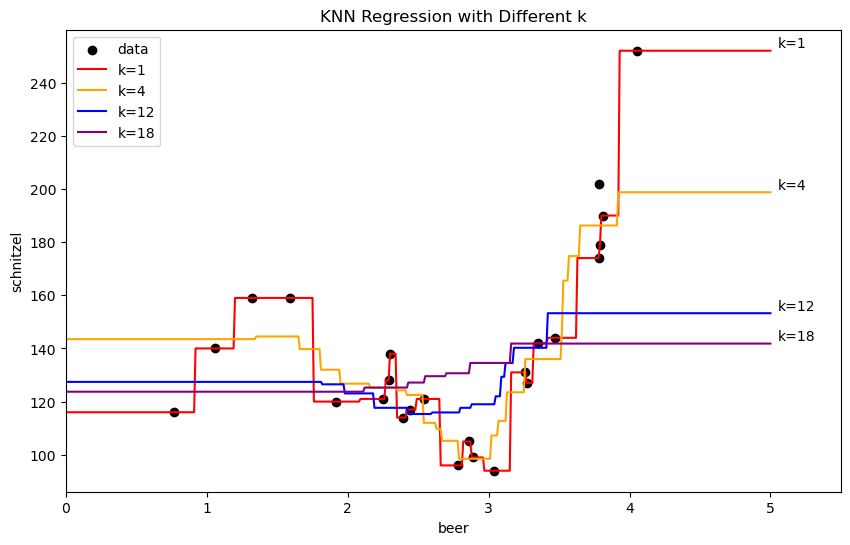

In [10]:
# Prediction space
predspace = np.arange(0, 5.01, 0.01).reshape(-1, 1)
n_cps = len(predspace)

# Training data
xt = oktoberfest[["beer"]].values  # shape (n, 1)
yt = oktoberfest["schnitzel"].values  # shape (n,)

# Fit KNN regressors
models = {
    "k=1": KNeighborsRegressor(n_neighbors=1),
    "k=4": KNeighborsRegressor(n_neighbors=4),
    "k=12": KNeighborsRegressor(n_neighbors=12),
    "k=18": KNeighborsRegressor(n_neighbors=18),
}

predictions = {}
for label, model in models.items():
    model.fit(xt, yt)
    predictions[label] = model.predict(predspace)

# Plot
plt.figure(figsize=(10, 6))

# Scatter of original data
plt.scatter(oktoberfest["beer"], oktoberfest["schnitzel"], label="data", color="black")

# Plot lines for each k
colors = {"k=1": "red", "k=4": "orange", "k=12": "blue", "k=18": "purple"}
for label, y_pred in predictions.items():
    plt.plot(predspace, y_pred, color=colors[label], label=label)

# Add text labels at x=5
for label, y_pred in predictions.items():
    plt.text(
        5.05,  # just outside the plot range
        y_pred[-1],
        label,
        va="bottom",
        fontsize=10,
    )

plt.xlabel("beer")
plt.ylabel("schnitzel")
plt.title("KNN Regression with Different k")
plt.xlim(0, 5.5)
plt.legend()
plt.show()


We'll use these functions to think through the following questions: 

## Comprehension Check

1. Why do the KNN learners "flatten out" at the very small and very big values of `beer`?
2. Which KNN learner do you think has the lowest error? 
3. Which KNN learner do you think represents the best tradeoff in terms of the bias-variance tradeoff? 
4. Assume that we have observed the following *validation values*:

|beer|schnitzel|
|----|---------|
|1   |127      |
|2   |127      |
|3   |98       |
|4   |225      |

Use the plot to approximately judge which model would have the best performance on this validation set. 


## Training a KNN learner yourself

To optimize our KNN learner using crossvalidation, we can use the `caret` package. This is a general-purpose interface to nearly any estimator you would want to use. [This is the table of the 238 (at the time of writing) estimators](https://topepo.github.io/caret/available-models.html) supported by `caret`. To fit a KNN, you set `method=knn`. 

In [11]:
X = oktoberfest[["beer"]]   # predictors
y = oktoberfest["schnitzel"]  # response

# model definition (same as caret::train(method="knn"))
knn = KNeighborsRegressor()

# cross-validation strategy (same as caret::trainControl(method="cv"))
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# apply
scores = cross_val_score(knn, X, y, cv=cv, scoring="r2")

print("Cross-validation R^2 scores:", scores)
print("Mean R^2:", np.mean(scores))

Cross-validation R^2 scores: [  0.83446575   0.45021035   0.55939942   0.79621302   0.94177999
  -1.98864198  -0.34276795 -44.776        0.72368889   0.14049587]
Mean R^2: -4.266115663673031


By default, `caret` will try to find a "good" value of $k$, but it often will not search enough values. To find a good value, you may need to specify the `tuneGrid` option. 
In Python, you can do the same thing with `GridSearchCV` from `scikit-learn` to serach within range of parameters:

In [12]:
 # Features and target
X = oktoberfest[["beer"]]
y = oktoberfest["schnitzel"]

# Define model
knn = KNeighborsRegressor()

# Cross-validation strategy (same as trainControl(method='cv'))
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Grid of k values from 1 to 18
param_grid = {"n_neighbors": list(range(1, 19))}

# Grid search with cross-validation
grid_r2 = GridSearchCV(knn, param_grid, cv=cv, scoring="r2")
grid_r2.fit(X, y)

print("Best k:", grid_r2.best_params_["n_neighbors"])
print("Best CV R^2:", grid_r2.best_score_)

Best k: 12
Best CV R^2: -2.0056424629298584



> As a general rule, if the "best" parameter you find sits at the very biggest (or very smallest), you may need to increase (or decrease) the upper (or lower) limit of the values you're searching! For KNN, $k>0$, so you can at least stop the search when $k=1$.


Objects fit using `caret::train()` always show a results table that contains many of the common scores/losses you might want to consider. In Python, we need to construct this table from the results:

In [13]:
results_r2 = pd.DataFrame(grid_r2.cv_results_)

results_r2[["param_n_neighbors", "mean_test_score", "std_test_score"]].head(3)


,param_n_neighbors,mean_test_score,std_test_score
0,1,-5.581095,13.961552
1,2,-8.763523,27.486685
2,3,-11.480677,35.534931


This makes it easy to plot the accuracy of the learner as a function of $k$:

While r caret calculates RMSE automatically, in python this is not the case. In scikit-learn, we need to set the scoring in GridSearchCV to either R2 as previously or for RMSE like this  `scoring="neg_root_mean_squared_error"`, so we simply repeat the rpevious step.

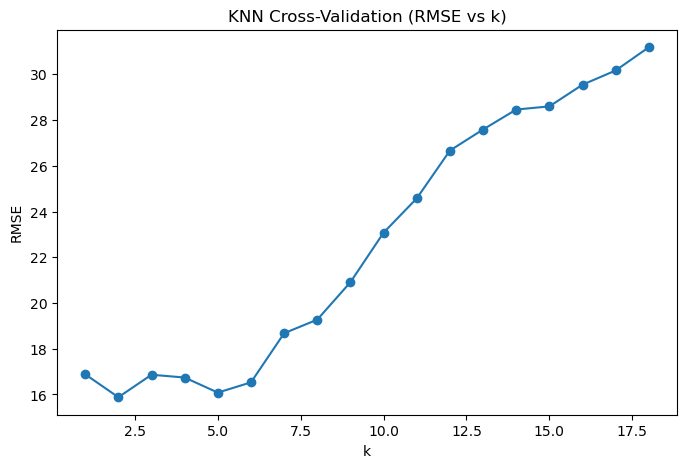

In [14]:
grid_rmse = GridSearchCV(knn, param_grid, cv=cv, scoring="neg_root_mean_squared_error", return_train_score=True)
grid_rmse.fit(X, y)

results_rmse = pd.DataFrame(grid_rmse.cv_results_)
results_rmse["RMSE"] = -results_rmse["mean_test_score"]

plt.figure(figsize=(8, 5))
plt.plot(results_rmse["param_n_neighbors"], results_rmse["RMSE"], marker="o")
plt.xlabel("k")
plt.ylabel("RMSE")
plt.title("KNN Cross-Validation (RMSE vs k)")
plt.show()

From this plot, you might think that choosing any $k<6$ is fairly defensible. By default, caret picks the model with the best RMSE and stores it under the `finalModel` attribute. In Python, this is stored during the gridsearch:

In [15]:
print("Best model:", grid_rmse.best_estimator_)

Best model: KNeighborsRegressor(n_neighbors=2)


The `caret::train()` function picks models with the lowest RMSE by default. This might not always pick the same model as other loss/gain functions. For example, we would pick a different model if we wanted to optimize our R-squared: 


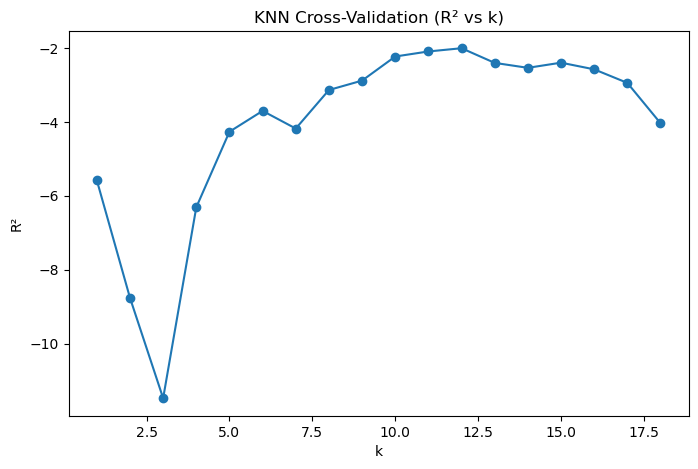

In [16]:
results_r2["Rsquared"] = results_r2["mean_test_score"]

plt.figure(figsize=(8, 5))
plt.plot(results_r2["param_n_neighbors"], results_r2["Rsquared"], marker="o")
plt.xlabel("k")
plt.ylabel("R²")
plt.title("KNN Cross-Validation (R² vs k)")
plt.show()


In R you can switch to other gain functions using the `maximize` argument:


In [17]:
X = oktoberfest[["beer"]]
y = oktoberfest["schnitzel"]

# model definition (same as caret::train(method="knn"))
knn = KNeighborsRegressor()

# cross-validation strategy (same as caret::trainControl(method="cv"))
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# parameter grid (k=1:18)
param_grid = {"n_neighbors": list(range(1, 19))}

# grid search with R2
grid_r2 = GridSearchCV(
    knn,
    param_grid,
    cv=cv,
    scoring="r2", # this is a built in scorer so by deafult the higher the better
    refit=True, # equivalent of the R argument 'maximize' = TRUE, however, if you use a custom scorer and 'the higher the better' no longer holds, you might need some adjustements
    return_train_score=True
)

grid_r2.fit(X, y)

# find the best k
final_model = grid_r2.best_estimator_

print("Best k:", grid_r2.best_params_["n_neighbors"])
print("Final model:", final_model)

Best k: 12
Final model: KNeighborsRegressor(n_neighbors=12)



Note that the exact value of $k$ can change depending on the random changes between cross-validation splits. Try proving this to yourself by training a knn model twice using the same options. In large data, this generally averages out, but to ensure you get the same results every time, make sure to give the `set.seed()`(R) or `random_state` (Python) a number, like your student number, your birthday, or some other number, to ensure that the randomness is the same every time. Usually, we set the seed once at the start, or once per chunk if you're repeating that chunk over and over again to troubleshoot. 


You can use this model to make predictions, too: 

In [ ]:

# define new data
new_data = pd.DataFrame({"beer": [1, 2, 3, 4]})

# use the final model (best estimator from CV)
preds = final_model.predict(new_data)  # or final_model.predict(new_data) if you used R²

# attach predictions to new data
new_data["prediction"] = preds

# display
new_data

,beer,prediction
0,1,127.416667
1,2,123.083333
2,3,119.000000
3,4,153.250000


## Comprehension Check
1. Fit the $k=1$, $k=4$, $k=12$, and $k=23$ models from the plot above. 

    a. Which one has the best validation error? You can use `yardstick::rsme_vec(prediction, known)`, which is the `rmse_vec()` function from the `yardstick` package, to calculate the RMSE of a vector of predictions and a vector of known values.  

    b. Does the model that has the lowest validation error match the one you expected to have the best bias-variance tradeoff? If they differ, why do you think they differ?

2. Fit a KNN model to the `Boston` data from ISL, predicting `medv` using `lstat`.
    a. What is the optimum $k$ value? 

    b. What is the predicted `medv` when `lstat` is 5, 10, and 15?

    c. How do these predictions differ from a linear model's predictions? 

    d. Which model do you expect to have a better model fit to *new data*?
    



## Common pitfalls with KNN

One common issue with KNN learners is that they are *interpolators*. That is, a KNN learner will never predict outside of the range of $y$ that has been observed. Many common models, such as random forests and decision trees which we will consider later in this unit, are also interpolators. These algorithms are often very good at achieving high accuracy when predicting *inside of* the range of the observed $y$ variable, but are generally unreliable for forecasting. 

Another common issue with KNN learners is that they do not handle categorical predictors well. A KNN algorithm can easily make *predictions* about categorical variables, but they have a hard time dealing with categorical $x$ variables. This is because of the issue of *ties*. Imagine you're predicting the price of a car based on its color. You have five "red" cars, seven "green" cars, and ten "blue" cars, all worth different prices. When $k=3$ and you're predicting about a "blue" car, which of the ten training points do you pick? All of them? Then, it's not a "knn" learner! If you want to be strict about $k$, you then must pick $k$ values *at random* when predicting a value for a "blue" car when $k$ is smaller than the number of observations within a group. Second, imagine if $k=8$ and you're predicting the value of a green car. Is "red" closer to "green" than "black"? If you can't decide, then do you pick at random from the "red" cars? or the "black" cars? or, do you pick randomly from all of the red and black cars? At its core, KNN learners work best when *distance is a natural, simple-to-interpret function on the $x$ variables*. For categorical $x$ or $x$ with many ties, this is often not the case, and this will make predictions based on a KNN learner less useful.

Another common issue with KNN is that they are *scale sensitive*. This means that the $k$ value that is discovered depends on the magnitude of $x$. This is *not* a problem when there is only one predictor, but as soon as there is more than one predictor, this can become a problem. 


## Comprehension check
1. Fit a KNN model to the `Boston` data from ISL, predicting `medv` using `lstat` and `age`. 

    a. What is the best value of $k$?

    b. Now, force the variables to be re-scaled to have a mean of zero and a variance of one using the `preProcess='scale'` option for `caret::train()`. What is the best value of $k$ there? Is the error higher or lower?

    c. What is the standard deviation of the `lstat` feature? How about the `age` feature? 

    d. If a test point is 1 unit away from a training point in model (a), what's the largest difference in `age` between the test point and the training point? How about `lstat`?

    e. If a test point is 1 unit away from a training point in model (b), what's the largest difference in `age` between the test point and training point? How about `lstat`?

    f. Given what you learned about (d) and (e), is the model from part (a) more sensitive to `age` or `lstat`? How about the model in part (b)?




> You can find the answers in the R version of this sheet, can you replicate the code in Python?
